In [1]:
# general packages
import os
import numpy as np
import pandas as pd
import random
# torch and related packages
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable as V
from torchsummary import summary 
# plotting packages
import matplotlib.pyplot as plt
# sklearn package 
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from IPython.display import clear_output

In [2]:
#Set device to GPU_indx if GPU is avaliable
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import the Raw Data

In [4]:
data=pd.read_csv('/content/drive/MyDrive/ECE4179 - Project /Dataset and Models/creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Visualising the data in term of Time window and Amount of transaction

In [5]:
# Get only the fraud transaction 
fraud = data[data['Class'] == 1]  # Sorting all fraud transactions
fraud_x = fraud['Time'].values
fraud_y = fraud['Amount'].values         

# Get half of only nomral tracsaction samples (non-fraud)
nonfraud = data[data['Class'] == 0]
nonfraud_x = nonfraud['Time'].values     
nonfraud_y = nonfraud['Amount'].values

In [6]:
fraud.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [7]:
nonfraud.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

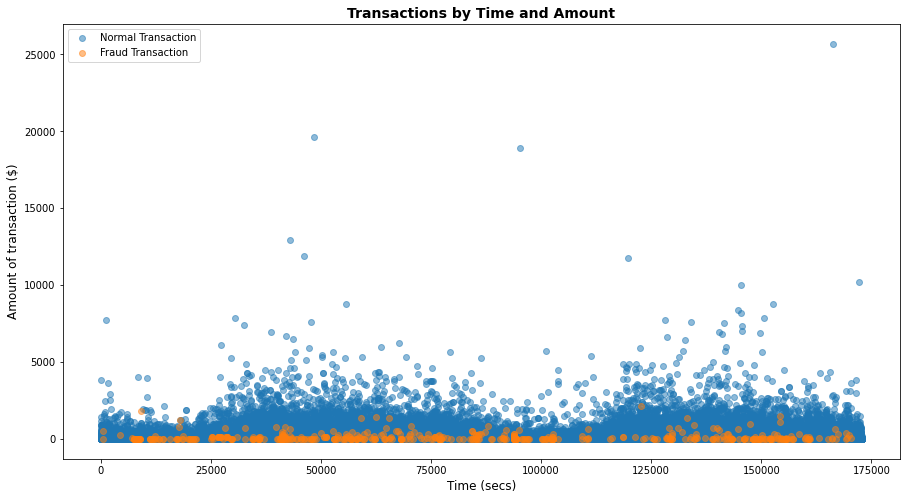

In [ ]:
plt.figure(figsize=(15,8))
plt.scatter(nonfraud_x, nonfraud_y, alpha=0.5, label='Normal Transaction')
plt.scatter(fraud_x, fraud_y, alpha=0.5, label='Fraud Transaction')
plt.xlabel('Time (secs)', fontsize=12)
plt.ylabel('Amount of transaction ($)', fontsize=12)
plt.title('Transactions by Time and Amount', fontsize=14, fontweight='bold')
plt.legend()
plt.show()

From the chart above it has showed that all the transactions is pretty random, it does not happen at a specific time window. The fraud transation will not involve a large amount of money.

# Clean the Data

In [8]:
# Delete the time column
data = data.drop('Time', axis=1)

In [9]:
# normalize the data
# normalize V1-V28, Amount (column 0 to 28)
def normalizeData(Data):
    for i in range((Data.shape[1])-1): #will not run through the last column
        Data[:,i] = preprocessing.normalize([Data[:,i]])
    return Data

In [10]:
datanorm = normalizeData(data.to_numpy())

fraud = datanorm[datanorm[:,-1] == 1]
nonfraud = datanorm[datanorm[:,-1] == 0]

# Split the data into 3 sets (train, validation, test) and Create DataLoader 

In [11]:
# Splitting the normal transaction data as test-train => 20%-80%
X_train, X_test = train_test_split(nonfraud, test_size=0.2, random_state = 42)
# Splitting the normal transaction data as val-train => 10%-70% (in total)
X_train, X_val = train_test_split(X_train, test_size=0.08, random_state = 42) #0.08*0.8 = 0.1

# training set only contain the normal transaction 
X_train = np.delete(X_train, obj=-1, axis=1)    #remove the class label, axis = 1 means column, obj=-1 last column
XTrain = torch.FloatTensor(X_train) 

# validation set only contain the normal transaction 
X_val = np.delete(X_val, obj=-1, axis=1)    #remove the class label, axis = 1 means column, obj=-1 last column
XVal = torch.FloatTensor(X_val) 

# Test set 
# add all the fraud data to test set 
X_test = np.append(X_test,fraud, axis=0)   # add all the fraud data to test set 
y_test = X_test[:,-1]
X_test = np.delete(X_test, obj=-1, axis=1)      #remove the class label, axis = 1 means column, obj=-1 last column
XTest = torch.FloatTensor(X_test)               

# Size of the X_train and X_test array
print(f'shape of training set: {XTrain.shape} | shape of validation set: {XVal.shape}| shape of test set: {XTest.shape}')

shape of training set: torch.Size([209255, 29]) | shape of validation set: torch.Size([18197, 29])| shape of test set: torch.Size([57355, 29])


Create the DataLoader 

In [12]:
trainloader = DataLoader(XTrain, batch_size=1000, shuffle=True)
testloader = DataLoader(XTest, batch_size=1000, shuffle=False)
valloader = DataLoader(XVal, batch_size=1000, shuffle=False)

print(f'batches in training set: {len(trainloader)} | batches in validation set: {len(valloader)} |batches in test set: {len(testloader)}')

batches in training set: 210 | batches in validation set: 19 |batches in test set: 58


# Autoencoder Model 

In [13]:
# Approach 1
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.layer1 = nn.Sequential(
            nn.Linear(29, 19),
            nn.Tanh(),
        )

        self.layer2 = nn.Sequential(
            nn.Linear(19, 9),
            nn.Tanh(),
            nn.Dropout(0.05),
        )
        
        # Decoder 
        self.layer3 = nn.Sequential(
            nn.Linear(9 , 19),
            nn.Tanh(),
        )

        self.layer4 = nn.Linear(19, 29)

    def forward(self, data):
        x = self.layer1(data)
        x = self.layer2(x)
        x = self.layer3(x)
        out = self.layer4(x)

        return (out)

### Training and Validation function 

In [ ]:
def train(model, dataloader, optimizer, loss_fn, loss_logger):
    for batch_idx, (data_x) in enumerate(dataloader):

        x = V(data_x.to(device)) # V is torch.autograd.Variables
        pre_out = model(x)
        loss = loss_fn(pre_out, x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_logger.append(loss.item())

    return loss_logger

In [ ]:
def validate(model, dataloader, loss_fn, valloss_logger):
    for batch_idx, (data_x) in enumerate(dataloader):
        x = V(data_x.to(device))
        pre_out = model(x)
        loss = loss_fn(pre_out, x)
    
    valloss_logger.append(loss.item())

    return valloss_logger

### Hyper-parameters

In [14]:
model = Autoencoder().to(device)
lr = 1e-4
nepochs = 100
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


### Training Loop

In [ ]:
train_losslogger , val_losslogger = [], []
train_meanloss, val_meanloss = [], []

for epoch in range (nepochs):
    train_losslogger = train(model, trainloader, optimizer, loss, train_losslogger)
    val_losslogger = validate(model, valloader, loss, val_losslogger)

    train_meanloss.append(np.mean(train_losslogger))
    val_meanloss.append(np.mean(val_losslogger))

    print(f'Epoch: {epoch+1}| Train_loss: {train_meanloss[epoch]} | Val_loss: {val_meanloss[epoch]}')
    clear_output(True)

Epoch: 100| Train_loss: 0.00027419313968982806 | Val_loss: 0.00014697531557203547


### Training Evaluation

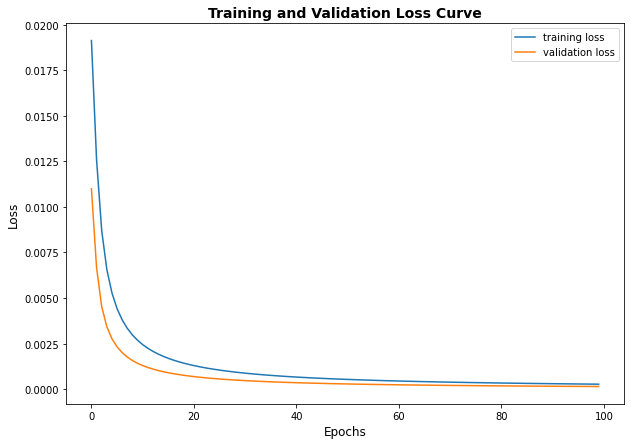

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(train_meanloss, label='training loss')
plt.plot(val_meanloss, label='validation loss')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss Curve', fontsize=14, fontweight='bold')
plt.legend()
plt.show()

In [ ]:
print(f'Minimum Training Loss: {min(train_meanloss)} | Minimum Validation Loss: {min(val_meanloss)}')

Minimum Training Loss: 0.00027419313968982806 | Minimum Validation Loss: 0.00014697531557203547


### Saving and Loading the trained model 

In [ ]:
# #save the model
# saved_model = "Autoencoder_Final.pth"
# path = F"/content/drive/MyDrive/ECE4179 - Project /Saved Model/{saved_model}"
# torch.save(model, path)

In [15]:
# load the saved model 
saved_model = "Autoencoder_Final.pth"
path = F"/content/drive/MyDrive/ECE4179 - Project /Dataset and Models/{saved_model}"
model = torch.load(path)
model.eval()

Autoencoder(
  (layer1): Sequential(
    (0): Linear(in_features=29, out_features=19, bias=True)
    (1): Tanh()
  )
  (layer2): Sequential(
    (0): Linear(in_features=19, out_features=9, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.05, inplace=False)
  )
  (layer3): Sequential(
    (0): Linear(in_features=9, out_features=19, bias=True)
    (1): Tanh()
  )
  (layer4): Linear(in_features=19, out_features=29, bias=True)
)

### Number of parameters 

In [16]:
summary(model,(284807,29))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1           [-1, 284807, 19]             570
              Tanh-2           [-1, 284807, 19]               0
            Linear-3            [-1, 284807, 9]             180
              Tanh-4            [-1, 284807, 9]               0
           Dropout-5            [-1, 284807, 9]               0
            Linear-6           [-1, 284807, 19]             190
              Tanh-7           [-1, 284807, 19]               0
            Linear-8           [-1, 284807, 29]             580
Total params: 1,520
Trainable params: 1,520
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 31.51
Forward/backward pass size (MB): 286.82
Params size (MB): 0.01
Estimated Total Size (MB): 318.34
----------------------------------------------------------------


# Classifier 

### Find the Threshold value using Validation set 

In [17]:
# Iterate through the dataloader and get predictions for each batch of the test set.
valData = iter(valloader)
Preds = np.vstack([model(V(next(valData).to(device))).cpu().data.numpy() for i in range(len(valData))])

# Determine the error between the actual account and the reconstructed account
error = np.mean(abs(X_val - Preds), axis = 1) #axis 1 -> along row 

In [18]:
# error is the mean difference btw the actual account and the predicted account for each sample 
threshold = (error.mean() + error.std())
print(f'The threshold is: {threshold}')

The threshold is: 0.0015577149116791072


### Use the Threshold to predict the label (fraud and non-fraud)

In [19]:
# Iterate through the dataloader and get predictions for each batch of the test set.
testData = iter(testloader)
test_pred = np.vstack([model(V(next(testData).to(device))).cpu().data.numpy() for i in range(len(testData))])

# Determine the error between the actual account and the reconstructed account
test_error = np.mean(abs(X_test - test_pred), axis = 1) #axis 1 -> along row 

In [20]:
# Compute the predicted y_test
y_testpred = []
for idx, err in enumerate (test_error):
    # if difference btw the actual account and the reconstructed account is > threshold == fraud 
    if err > threshold: class_pred = 1
    else: class_pred = 0
    
    y_testpred.append(class_pred)

# Confusion Matrix

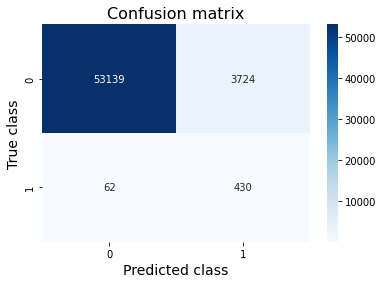

In [21]:
import seaborn as sns

cmatrix = metrics.confusion_matrix(y_test, y_testpred)
sns.heatmap(cmatrix, annot=True, fmt='.0f', cmap='Blues')
plt.title('Confusion matrix', fontsize=16)
plt.xlabel('Predicted class',fontsize=14)
plt.ylabel('True class', fontsize=14)
plt.show()